# Machine Learning 2 Project -  *K - means*

## About k-Means

- K-means typically uses Euclidean distance. It minimizes least squares, which makes only sense on continuous variables.
- They also need to behave linearly. If you have multiple variables, they also need to have the same magnitude.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [ ]:
df_int.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9866 entries, 6f807x0ima9a1j3VPbc7VN to 37gl0hLcFHMVKCLe9gn36a
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      9866 non-null   float64
 1   energy            9866 non-null   float64
 2   loudness          9866 non-null   float64
 3   speechiness       9866 non-null   float64
 4   acousticness      9866 non-null   float64
 5   instrumentalness  9866 non-null   float64
 6   liveness          9866 non-null   float64
 7   valence           9866 non-null   float64
 8   tempo             9866 non-null   float64
 9   duration_ms       9866 non-null   float64
 10  popularity_class  9866 non-null   int64  
 11  cluster           9866 non-null   int32  
dtypes: float64(10), int32(1), int64(1)
memory usage: 1.2+ MB


## 1.Initial data treatment


In [ ]:
df = pd.read_parquet('spotify_songs.parquet')

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.shape

(32828, 22)

In [ ]:
df.columns

Index(['track_name', 'track_artist', 'track_popularity', 'track_album_id',
       'track_album_name', 'track_album_release_date', 'playlist_name',
       'playlist_id', 'playlist_genre', 'playlist_subgenre', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'],
      dtype='object')

In [ ]:
# Converting 'track_popularity' to categorical labels
def classify_popularity(popularity):
    if popularity <= 20:
        return 0
    elif popularity <= 40:
        return 1
    elif popularity <= 60:
        return 2
    else:
        return 3

df['popularity_class'] = df['track_popularity'].apply(classify_popularity)

In [ ]:
# filtering to only keep the 2019 year

# Convert 'track_album_release_date' to datetime
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'])

# Extract year, month, day information
df['release_year'] = df['track_album_release_date'].dt.year

filtered_df = df[df['release_year'] >= 2019]
# Drop the original 'track_album_release_date' column
filtered_df.drop(columns=['track_album_release_date', 'release_year','track_popularity'], inplace=True)

ValueError: time data "2012" doesn't match format "%Y-%m-%d", at position 96. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32828 entries, 6f807x0ima9a1j3VPbc7VN to 29zWqhca3zt5NsckZqDf6c
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_name                32828 non-null  object 
 1   track_artist              32828 non-null  object 
 2   track_popularity          32828 non-null  int64  
 3   track_album_id            32828 non-null  object 
 4   track_album_name          32828 non-null  object 
 5   track_album_release_date  32828 non-null  object 
 6   playlist_name             32828 non-null  object 
 7   playlist_id               32828 non-null  object 
 8   playlist_genre            32828 non-null  object 
 9   playlist_subgenre         32828 non-null  object 
 10  danceability              32828 non-null  float64
 11  energy                    32828 non-null  float64
 12  key                       32828 non-null  int64  
 13  loudness                  32

In [ ]:
#creating a new dataset df_int with only the int features:
df.select_dtypes(['float', 'int']).describe()
df_int = df.select_dtypes(['float', 'int'])


In [ ]:
#droping the columns mode and key cause they are not appropriate for the model
df_int.drop(columns = ['mode', 'key'], inplace = True)

KeyError: "['mode', 'key'] not found in axis"

In [ ]:
df_int.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity_class
count,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000,32828.000000
mean,0.654850,0.698603,-6.719529,0.107053,0.175352,0.084760,0.190175,0.510556,120.883642,225796.829779,1.614628
std,0.145092,0.180916,2.988641,0.101307,0.219644,0.224245,0.154313,0.233152,26.903632,59836.492346,1.110844
min,0.000000,0.000175,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000,0.000000
25%,0.563000,0.581000,-8.171250,0.041000,0.015100,0.000000,0.092700,0.331000,99.961000,187804.500000,1.000000
50%,0.672000,0.721000,-6.166000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000,2.000000
75%,0.761000,0.840000,-4.645000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918250,253581.250000,3.000000
max,0.983000,1.000000,1.275000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000,3.000000


## 2.Data Normalization
Lets normarlize the already treated dataset 'df_int' using Min Max Scaler.

In [ ]:
df_int = pd.read_parquet('df_int.parquet')

In [ ]:
df_int.shape

(9866, 11)

In [ ]:
df_int.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity_class
count,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000
mean,0.677038,0.694607,-6.333093,0.114021,0.191300,0.094689,0.185388,0.481208,122.281154,197697.808230,1.933509
std,0.135517,0.178256,2.762711,0.101196,0.225466,0.239140,0.146680,0.225917,26.684760,44750.557327,0.938795
min,0.077100,0.016700,-26.207000,0.023000,0.000001,0.000000,0.013100,0.000010,35.477000,54656.000000,0.000000
25%,0.592000,0.580000,-7.614000,0.044700,0.018900,0.000000,0.095325,0.307000,100.416750,170063.500000,1.000000
50%,0.691000,0.712000,-5.858500,0.071650,0.101000,0.000009,0.125000,0.478000,123.951500,192839.000000,2.000000
75%,0.775000,0.831000,-4.458000,0.146000,0.288000,0.004320,0.231000,0.654000,135.817000,218182.000000,3.000000
max,0.979000,1.000000,0.326000,0.877000,0.986000,0.994000,0.979000,0.981000,219.991000,515703.000000,3.000000


In [ ]:
#normalizing data
numerical_columns = ['danceability', 'energy',  'loudness',  'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
scaler = MinMaxScaler()
df_int[numerical_columns] = scaler.fit_transform(df_int[numerical_columns])

In [ ]:
df_int.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity_class
count,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000
mean,0.665193,0.689421,0.749026,0.106582,0.194015,0.095261,0.178371,0.490523,0.470448,0.310254,1.933509
std,0.150257,0.181283,0.104124,0.118496,0.228667,0.240584,0.151859,0.230294,0.144622,0.097063,0.938795
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.570906,0.572867,0.700750,0.025410,0.019167,0.000000,0.085128,0.312939,0.351950,0.250316,1.000000
50%,0.680674,0.707109,0.766913,0.056967,0.102433,0.000009,0.115851,0.487253,0.479500,0.299716,2.000000
75%,0.773811,0.828130,0.819696,0.144028,0.292088,0.004346,0.225593,0.666663,0.543807,0.354684,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


## 3.Análise Exploratória dos Dados  


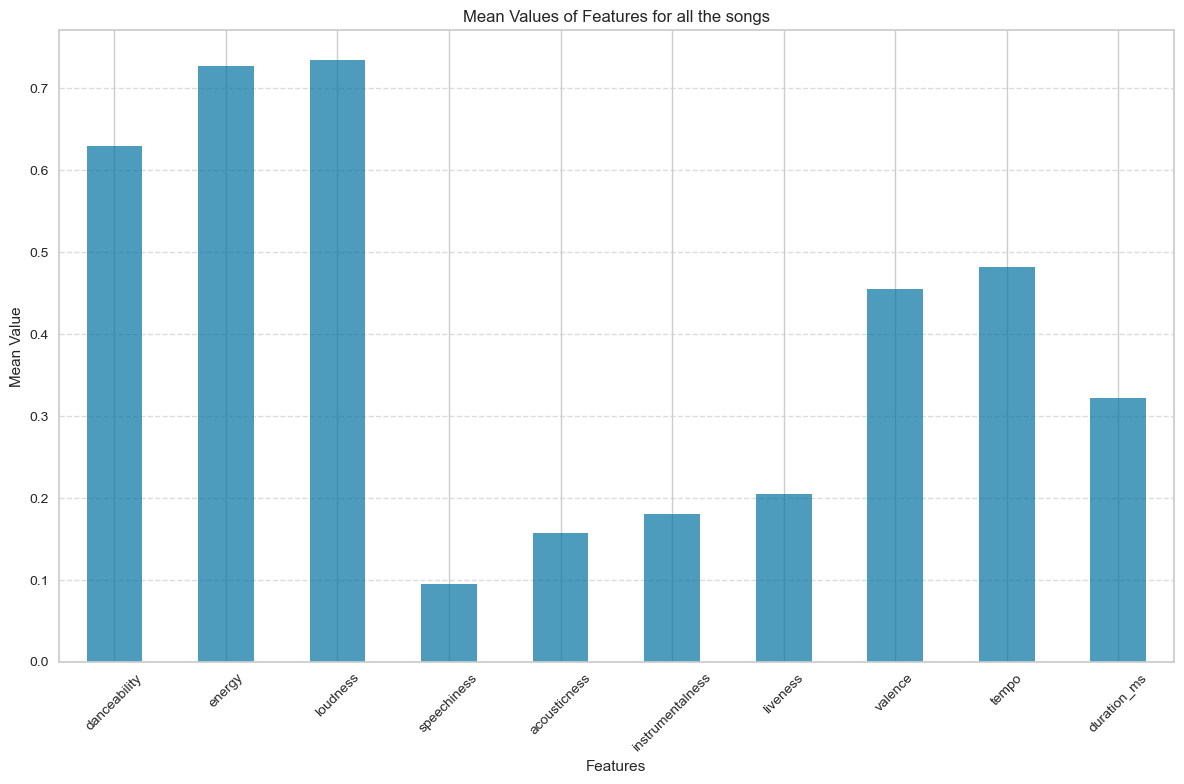

In [ ]:
# Select desired features
selected_features = ['danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# Calculate means for each feature
feature_means = popular_songs[selected_features].mean()

# Create a bar plot for feature means
plt.figure(figsize=(12, 8))
feature_means.plot(kind='bar', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean Values of Features for all the songs')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

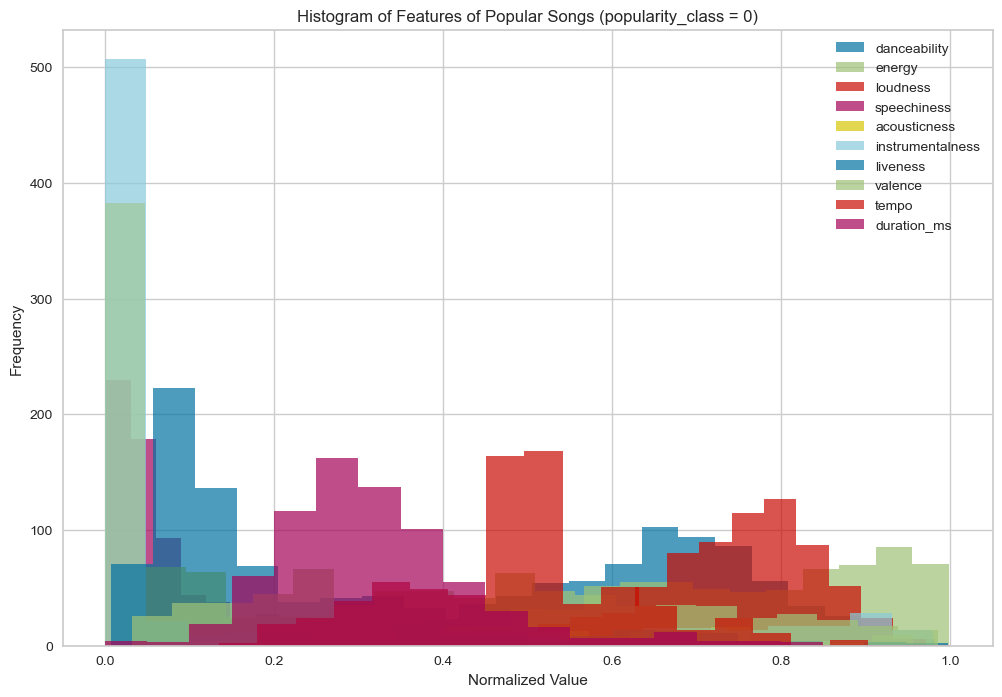

In [ ]:
# Filter songs with popularity_class = 0
popular_songs = df_int[df_int['popularity_class'] == 0]

# Select desired features
selected_features = ['danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# Create a histogram for each feature
plt.figure(figsize=(12, 8))

for feature in selected_features:
    plt.hist(popular_songs[feature], bins=20, alpha=0.7, label=feature)

plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.title('Histogram of Features of Popular Songs (popularity_class = 0)')
plt.legend()
plt.show()

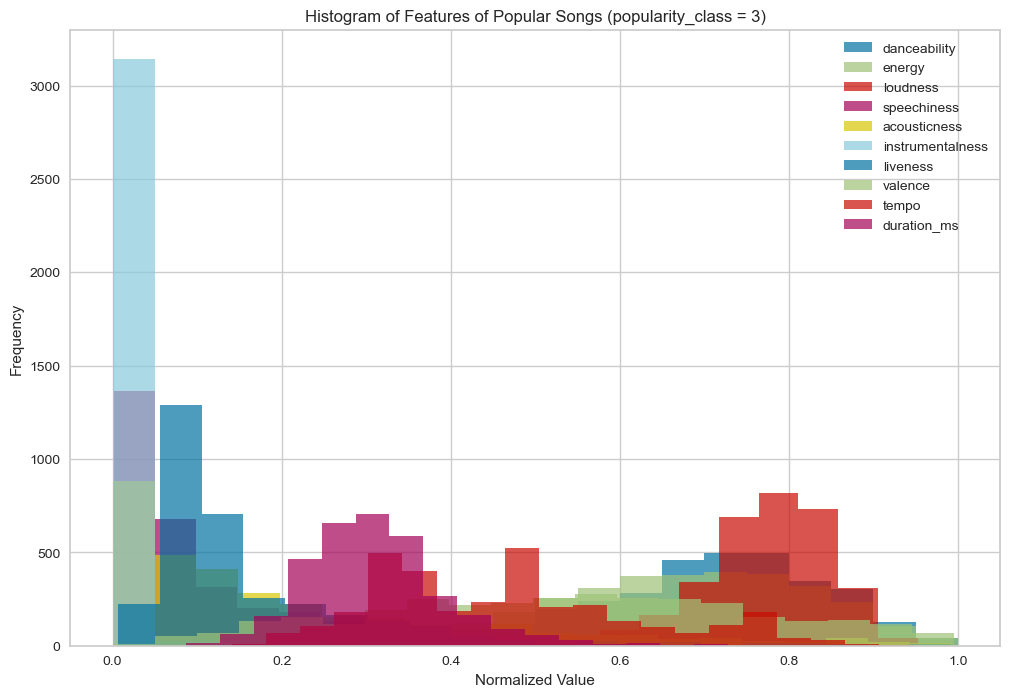

In [ ]:
# Filter songs with popularity_class = 3
popular_songs = df_int[df_int['popularity_class'] == 3]

# Select desired features
selected_features = ['danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

# Create a histogram for each feature
plt.figure(figsize=(12, 8))

for feature in selected_features:
    plt.hist(popular_songs[feature], bins=20, alpha=0.7, label=feature)

plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.title('Histogram of Features of Popular Songs (popularity_class = 3)')
plt.legend()
plt.show()

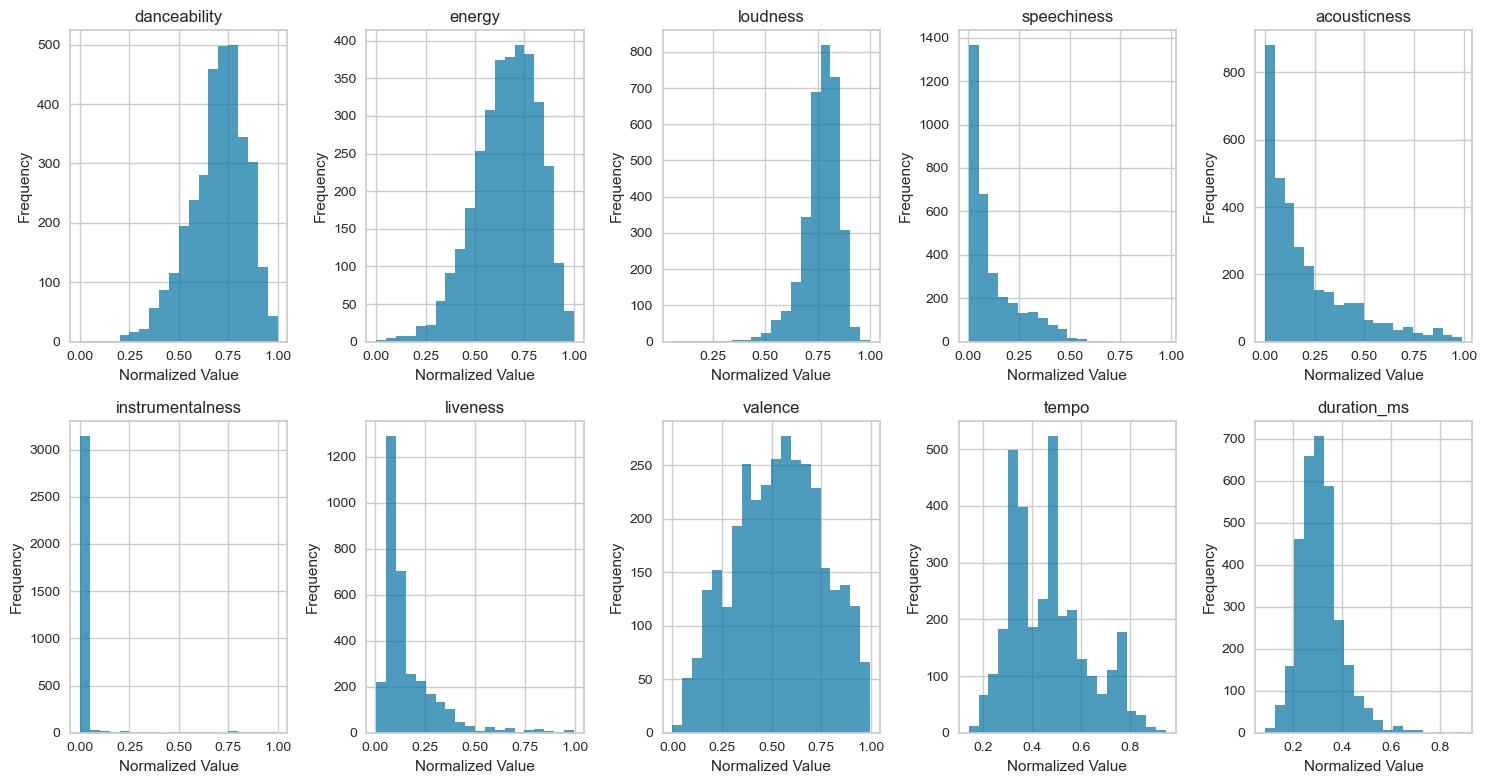

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Filter songs with popularity_class = 3
popular_songs = df_int[df_int['popularity_class'] == 3 ]

# Select desired features
selected_features = ['danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


# Creating subplots for each feature
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    axes[i].hist(popular_songs[feature], bins=20, alpha=0.7)
    axes[i].set_title(feature)
    axes[i].set_xlabel('Normalized Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


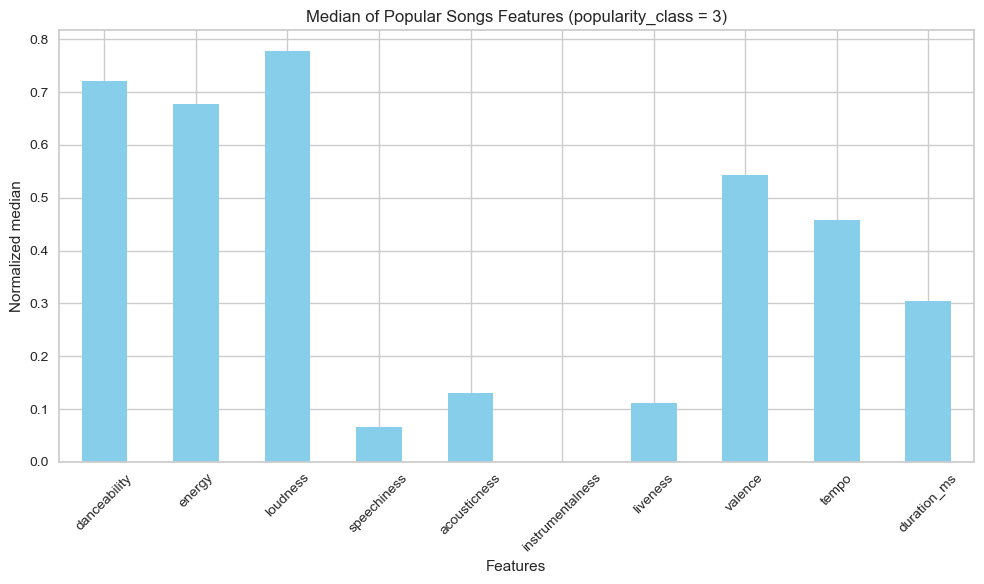

In [ ]:

# Filter songs with popularity_class = 3
popular_songs = df_int[df_int['popularity_class'] == 3]

selected_features = ['danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


medians = popular_songs[selected_features].median()

plt.figure(figsize=(10, 6))
medians.plot(kind='bar', color='skyblue')
plt.xlabel('Features')
plt.ylabel('Normalized median')
plt.title('Median of Popular Songs Features (popularity_class = 3)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/9z/cjhp10wn1xx1tk0nxvc3dm2h0000gn/T/ipykernel_73416/2133645907.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[selected_features] = scaler.fit_transform(dataset[selected_features])
/var/folders/9z/cjhp10wn1xx1tk0nxvc3dm2h0000gn/T/ipykernel_73416/2133645907.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[selected_features] = scaler.fit_transform(dataset[selected_features])
/var/folders/9z/cjhp10wn1xx1tk0nxvc3dm2h0000gn/T/ipykernel_73416/2133645907.py:15: SettingWithCopy

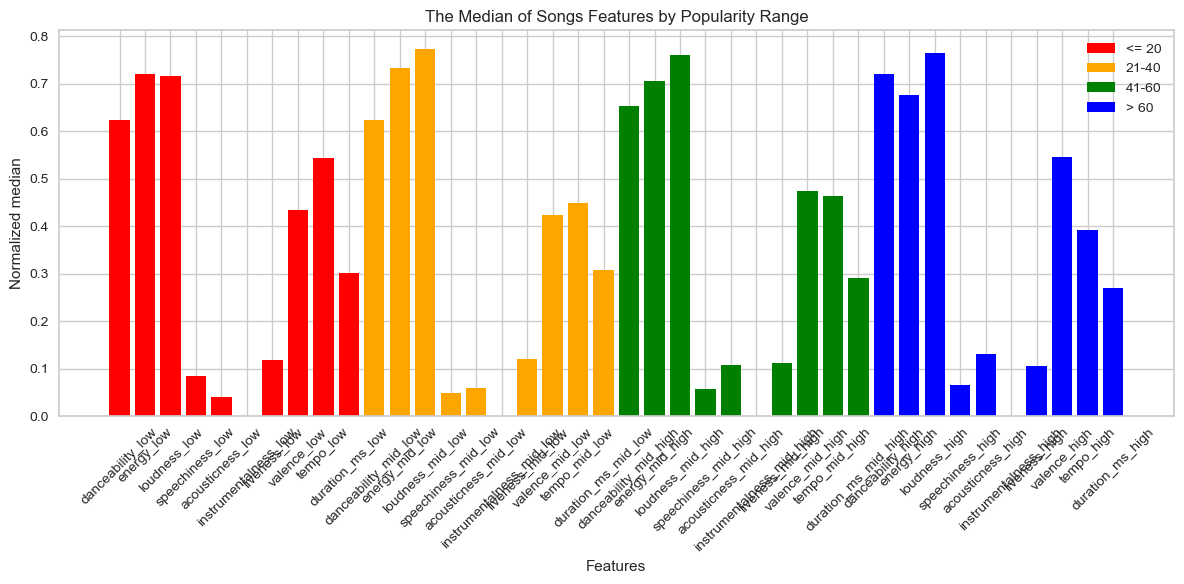

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Filtering songs by different popularity ranges
df_int_low = df_int[df_int['popularity_class'] == 0]
df_int_mid_low = df_int[df_int['popularity_class'] == 1]
df_int_mid_high = df_int[df_int['popularity_class'] == 2]
df_int_high = df_int[df_int['popularity_class'] == 3]

selected_features = ['danceability', 'energy', 'loudness', 'speechiness',
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

for dataset in [df_int_low, df_int_mid_low, df_int_mid_high, df_int_high]:
    dataset[selected_features] = scaler.fit_transform(dataset[selected_features])

#calculating each feature median by different popularity ranges
medians_low = df_int_low[selected_features].median()
medians_mid_low = df_int_mid_low[selected_features].median()
medians_mid_high = df_int_mid_high[selected_features].median()
medians_high = df_int_high[selected_features].median()


plt.figure(figsize=(12, 6))

plt.bar(medians_low.index + '_low', medians_low.values, color='red', label='<= 20')
plt.bar(medians_mid_low.index + '_mid_low', medians_mid_low.values, color='orange', label='21-40')
plt.bar(medians_mid_high.index + '_mid_high', medians_mid_high.values, color='green', label='41-60')
plt.bar(medians_high.index + '_high', medians_high.values, color='blue', label='> 60')

plt.xlabel('Features')
plt.ylabel('Normalized median')
plt.title('The Median of Songs Features by Popularity Range')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


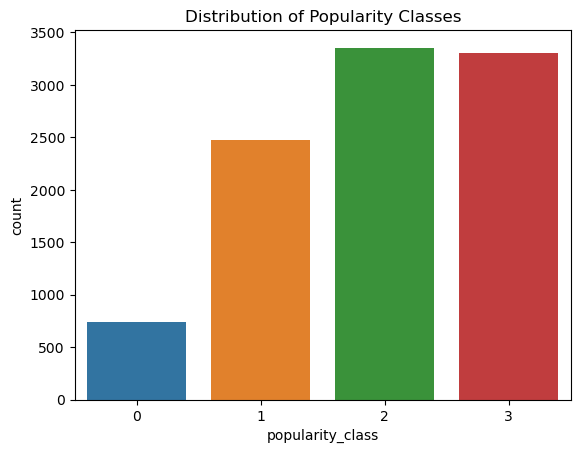

In [ ]:
# Distribuição
sns.countplot(x='popularity_class', data=df_int)
plt.title('Distribution of Popularity Classes')
plt.show()

## 4.K-means

Até o momento já filtramos para manter apenas as features de valores numéricos contínuos, popularity_class será o target.
Além disso os dados foram normalizados, conforme verificado na etapa 1.

In [ ]:
# Initializing KMeans
kmeans = KMeans(n_clusters= 4, random_state=42)

#defining X
columns_for_clustering = ['danceability', 'energy',  'loudness',  'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
X = df_int[columns_for_clustering]

#applying K-means
kmeans.fit(X)

df_int['cluster'] = kmeans.labels_

pred = kmeans.predict(X)

#visualizing the result
df_int.head()

/Users/luanaferraz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity_class,cluster
track_id,,,,,,,,,,,,
6f807x0ima9a1j3VPbc7VN,0.743874,0.914573,0.888441,0.041335,0.103447,0.000000,0.054043,0.528028,0.469119,0.303869,3,1
0r7CVbZTWZgbTCYdfa2P31,0.719481,0.811858,0.800437,0.016745,0.073427,0.004235,0.356041,0.706419,0.349540,0.234128,3,1
1z1Hg7Vb0AhHDiEmnDE79l,0.662934,0.929828,0.858365,0.059953,0.080526,0.000023,0.100321,0.624869,0.479806,0.264528,3,1
75FpbthrwQmzHlBJLuGdC7,0.710611,0.928811,0.845325,0.092506,0.029106,0.000009,0.197640,0.282358,0.468685,0.248211,2,0
1e8PAfcKUYoKkxPhrHqw4x,0.635215,0.830164,0.811631,0.015105,0.081439,0.000000,0.072678,0.739039,0.479633,0.291502,3,1


In [ ]:
kmeans.labels_

array([1, 1, 1, ..., 3, 0, 3], dtype=int32)

In [ ]:
#visualizing the result
df_int.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity_class,cluster
track_id,,,,,,,,,,,,
6f807x0ima9a1j3VPbc7VN,0.743874,0.914573,0.888441,0.041335,0.103447,0.000000,0.054043,0.528028,0.469119,0.303869,3,1
0r7CVbZTWZgbTCYdfa2P31,0.719481,0.811858,0.800437,0.016745,0.073427,0.004235,0.356041,0.706419,0.349540,0.234128,3,1
1z1Hg7Vb0AhHDiEmnDE79l,0.662934,0.929828,0.858365,0.059953,0.080526,0.000023,0.100321,0.624869,0.479806,0.264528,3,1
75FpbthrwQmzHlBJLuGdC7,0.710611,0.928811,0.845325,0.092506,0.029106,0.000009,0.197640,0.282358,0.468685,0.248211,2,0
1e8PAfcKUYoKkxPhrHqw4x,0.635215,0.830164,0.811631,0.015105,0.081439,0.000000,0.072678,0.739039,0.479633,0.291502,3,1


In [ ]:
df_int.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,popularity_class,cluster
count,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000
mean,0.665193,0.689421,0.749026,0.106582,0.194015,0.095261,0.178371,0.490523,0.470448,0.310254,1.933509,1.018042
std,0.150257,0.181283,0.104124,0.118496,0.228667,0.240584,0.151859,0.230294,0.144622,0.097063,0.938795,0.954770
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.570906,0.572867,0.700750,0.025410,0.019167,0.000000,0.085128,0.312939,0.351950,0.250316,1.000000,0.000000
50%,0.680674,0.707109,0.766913,0.056967,0.102433,0.000009,0.115851,0.487253,0.479500,0.299716,2.000000,1.000000
75%,0.773811,0.828130,0.819696,0.144028,0.292088,0.004346,0.225593,0.666663,0.543807,0.354684,3.000000,2.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000


### Elbow Method

/Users/luanaferraz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/luanaferraz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/luanaferraz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/luanaferraz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_

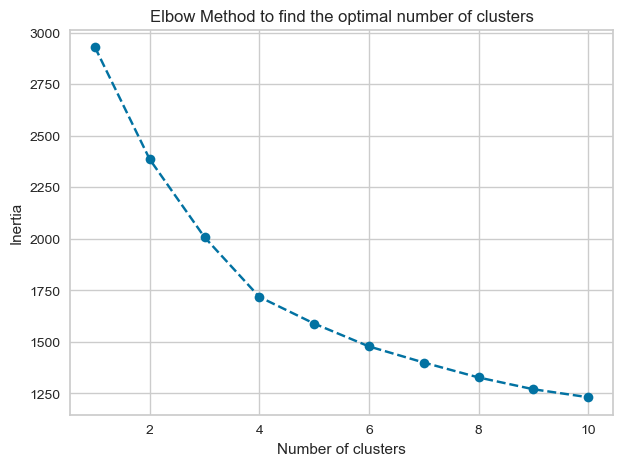

In [ ]:
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.figure(figsize=(7, 5))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to find the optimal number of clusters')
plt.show()

So, according to the elbow method the optimum number of clusters is 4

### Silhouette Score

/Users/luanaferraz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/luanaferraz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/luanaferraz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/luanaferraz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_

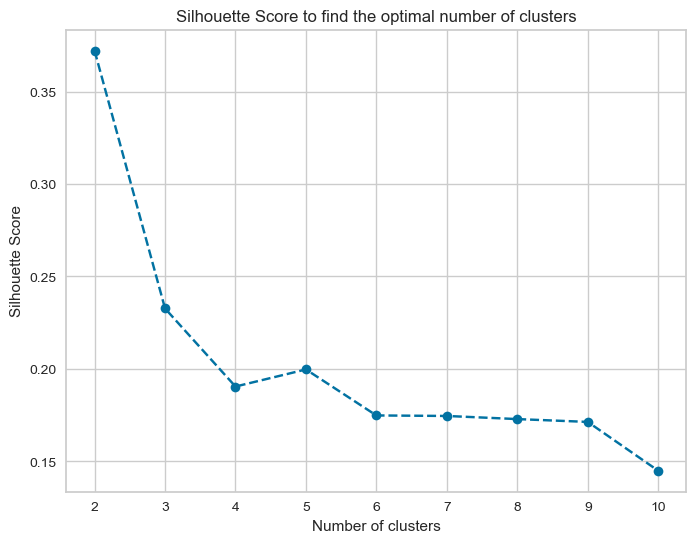

In [ ]:
# List to store Silhouette Score values
silhouette_scores = []

# Testing different numbers of clusters
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Plotting the Silhouette Score graph
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score to find the optimal number of clusters')
plt.show()

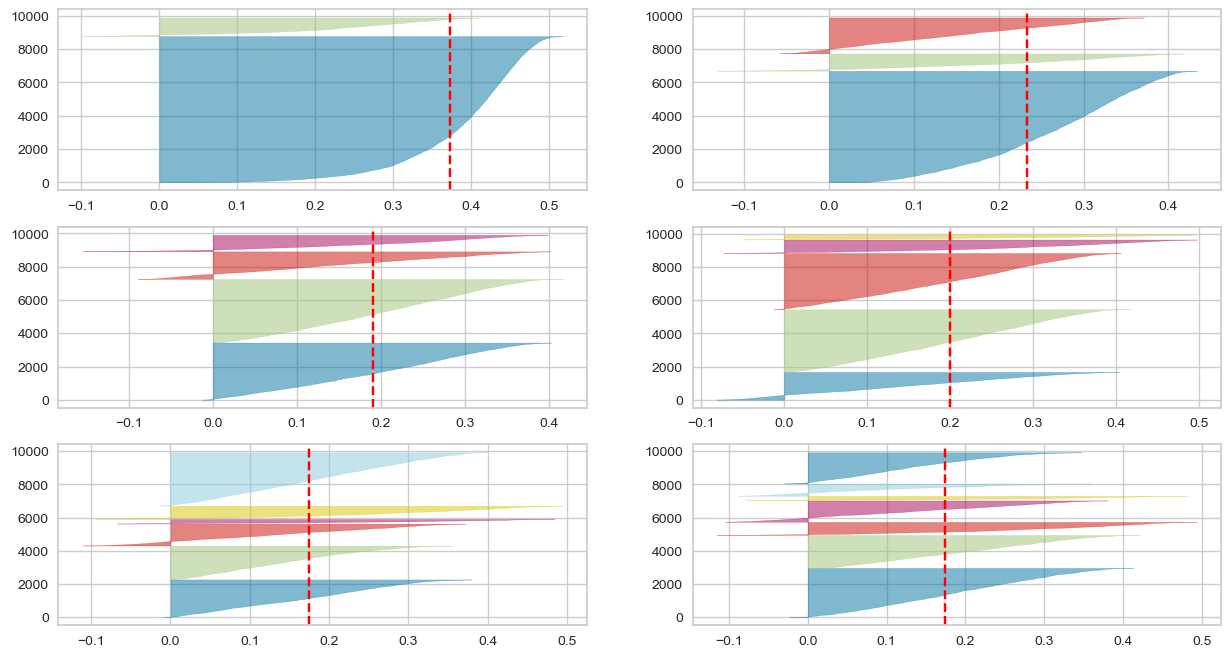

In [ ]:
fig, ax = plt.subplots(3,2, figsize = (15,8))

for i in [2,3,4,5,6,7]:

    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod= divmod(i,2)

    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

### PCA

Text(0.5, 0, 'Componente Principal 1')

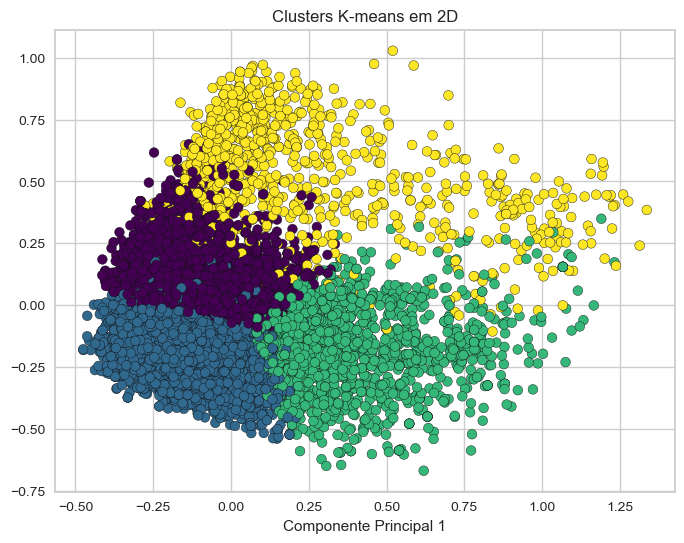

In [ ]:
# Reducing dimensionality for 2D plotting
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Plotting clusters on a 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans.labels_, cmap='viridis', edgecolor='k')
plt.title('K-means Clusters in 2D')
plt.xlabel('Principal Component 1')
